In [70]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GroupShuffleSplit # ensures don't mix series
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

df = pd.read_csv("../data/processed/cleaned_data.csv")

df.head()

,Series,Contestant,score_ep1,ppt_ep1,final_pct_points
0,1,Frank Skinner,19,3.8,0.2133
1,1,Josh Widdicombe,13,2.6,0.2156
2,1,Roisin Conaty,7,1.4,0.1560
3,1,Romesh Ranganathan,19,3.8,0.2133
4,1,Tim Key,17,3.4,0.2018


In [71]:
features = ["score_ep1", "ppt_ep1"] # explanatory variables
target = "final_pct_points" # scalar response
groups = df["Series"] # contestants within a series aren't independent, they compete with each other. I also want to train on some series and test on others.

In [72]:
# Create a Group shuffle split object using library imported above

# Split the data into training/test sets but make sure that all rows from the same group (Taskmaster series) stay together

# set up
gss = GroupShuffleSplit(
    n_splits=1,        # create *one* train/test split
    test_size=0.2,     # 20% of the series will be held out for testing
    random_state=42    # Fixed seed for debugging
)

# do the split

# gss.split() creates:
# 1. an index identifying the training set rows
# 2. an index identifying the test set rows

# to do this pass to the function:
# df[features]: the input features (Episode 1 data - the explanatory variables)
# df[target]: the target variable (final performance - the scalar response)
# groups: the grouping variable (the series)

# need next to extract the split
# perform the split
train_idx, test_idx = next(
    gss.split(df[features], df[target], groups))

# train_idx and test_idx identify the rows for the training and target sets (finally)

## Explanatory variables
# produce dataframes for the training set using the train_idx
# This contains Ep1 explanatory variables for contestants in the **training** series
X_train = df.loc[train_idx, features]

# produce dataframes for the test set using the test_idx
# This contains Ep1 explanatory variables for contestants in **test** series
X_test = df.loc[test_idx, features]

## Scalar responses
# Select the training scalar responses
# These are the outcomes for the **training** series
y_train = df.loc[train_idx, target]

# Select the test scalar responses
# These are the outcomes for the **test** series
y_test = df.loc[test_idx, target]

In [78]:
# Calculate the baseline prediction.
# This represents the simplest possible model: 
# predict the *average* final performance observed in the training data.

baseline_prediction = y_train.mean()

# Create an array of baseline predictions for the test set.
# np.full_like() creates an array with the same shape as y_test,
# where every value is the baseline_prediction (i.e. using the average)

# i.e. for every contestant in the test set
# it predicts the same "average contestant" outcome.
y_pred_baseline = np.full_like(y_test, baseline_prediction)

# Calculate the Mean Absolute Error (MAE) of the baseline model.
# MAE measures the average absolute difference between
# the actual final performance and the baseline prediction.
# i.e. how big is our average error between the forecast contestant performance and actual contestant performance?

mae_baseline = mean_absolute_error(y_test, y_pred_baseline)

# Calculate the Root Mean Squared Error of the baseline model.
# RMSE penalises larger errors more heavily than MAE, making it sensitive to large mispredictions.
# same as above but using a different method of evaluation

rmse_baseline = mean_squared_error(
    y_test,
    y_pred_baseline,
    squared=False)  # Setting squared=False returns RMSE instead of MSE


# Print the baseline error metrics, rounded to three decimal places.
# These values tell us how well our very basic model (using averages) performs.

mae_baseline_format = (mae_baseline * 100).round(1).astype(str) + "%"
rmse_baseline_format = (rmse_baseline * 100).round(1).astype(str) + "%"

print(f"Baseline MAE: {mae_baseline:.3f}")
print(f"Baseline RMSE: {rmse_baseline:.3f}")

print("\nExplanation:")
print(f"On average, this means that predictions made using a basic model are off by approx Baseline MAE: {mae_baseline_format} percentage points")
print(f"Or using Baseline RMSE (more sensitive to larger errors): {rmse_baseline_format} percentage points")


Baseline MAE: 0.015
Baseline RMSE: 0.018

Explanation:
On average, this means that predictions made using a basic model are off by approx Baseline MAE: 1.5% percentage points
Or using Baseline RMSE (more sensitive to larger errors): 1.8% percentage points


In [65]:
# create a new linear regression model 
# this tries to estimate a value of y (the scalar response - series overall performance) for 
# any value of x (the explanatory variables - performance in ep 1) - need to find a line of best fit.
# there are different methods to try to minimise the 'residual values'

model = LinearRegression()

# get the model to learn from our data using the training data only
model.fit(X_train, y_train)

LinearRegression()

In [66]:
# using the TEST explanatory variables, use the model to estimate the outcome for each contestant (in y_pred)
y_pred = model.predict(X_test)

# as before, calculate the errors between the model predictions and the test data
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# this is an improvement on the baseline model - good!

print(f"Linear Regression MAE: {mae:.3f}")
if mae < mae_baseline:
    print(f"The Linear regression model vs the baseline model shows a reduced MAE rate from {mae_baseline:.3f} to {mae:.3f}")

print(f"\nLinear Regression RMSE: {rmse:.3f}")
if rmse < rmse_baseline:
    print(f"The Linear regression model vs the baseline model shows a reduced RMSE rate from {rmse_baseline:.3f} to {rmse:.3f}")


Linear Regression MAE: 0.011
The Linear regression model vs the baseline model shows a reduced MAE rate from 0.015 to 0.011

Linear Regression RMSE: 0.014
The Linear regression model vs the baseline model shows a reduced RMSE rate from 0.018 to 0.014


In [67]:
# Create a table to show how much each explanatory variable affects the scalar response
# Each coefficient tells you how much the target (y) changes for a 1-unit change in 
# that feature, assuming all other features are constant.

# Positive coefficient = target increases as feature increases.

coefficients = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_
})

display(coefficients)

# This shows that the *score* on episode 1 has a greater effect than *points per task* in episode 1 on 
# the series % of points scored.

,Feature,Coefficient
0,score_ep1,0.002599
1,ppt_ep1,0.000520


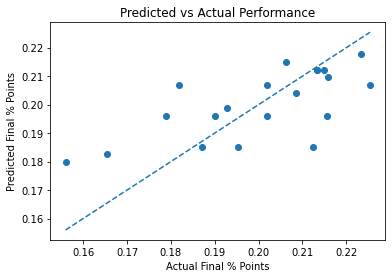

In [68]:
# Plot my results

import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")

plt.xlabel("Actual Final % Points")
plt.ylabel("Predicted Final % Points")
plt.title("Predicted vs Actual Performance")
plt.show()

In [69]:
# Show table of model forecasts vs actual results

# Combine test set information into a single df for display

test_results = X_test.copy()  # start with  features of test set
test_results["Contestant"] = df.loc[test_idx, "Contestant"]  # add contestant names
test_results["Series"] = df.loc[test_idx, "Series"]          # add series info
test_results["Actual_Final_Pct"] = y_test                   # add actuak final % points
test_results["Predicted_Final_Pct"] = y_pred                # add model predictions

# reorder columns
test_results = test_results[["Series", "Contestant", "score_ep1", "ppt_ep1", "Actual_Final_Pct", "Predicted_Final_Pct"]]

# Add column for prediction error
test_results["Prediction_Error"] = test_results["Predicted_Final_Pct"] - test_results["Actual_Final_Pct"]

# Sort to see the biggest over-predictions first
test_results = test_results.sort_values(by="Prediction_Error", ascending=False)

# convert decimals to percentages for presentation
test_results["Actual_Final_Pct"] = (test_results["Actual_Final_Pct"] * 100).round(1).astype(str) + "%"
test_results["Predicted_Final_Pct"] = (test_results["Predicted_Final_Pct"]* 100).round(1).astype(str) + "%"
test_results["Prediction_Error"] = (test_results["Prediction_Error"] * 100).round(1).astype(str) + "%"

# round PPT score to 1dp
test_results["ppt_ep1"] = (test_results["ppt_ep1"]).round(1).astype(str)

# retitle columns
test_results = test_results.rename(columns={
    "score_ep1": "Score After Ep 1",
    "ppt_ep1": "Points Per Task Score After Ep 1",
    "Actual_Final_Pct": "Actual Percentage of Total Points Won in Series",
    "Predicted_Final_Pct": "Predicted Percentage of Total Points Won in Series",
    "Prediction_Error": "Prediction Error (Percentage Points)"})

# Display the results

print("Model results from contestant with the highest over-prediction (more optimistic than actual score) to lowest under-prediction (more pesimistic than actual score):\n")

display(test_results.style.hide_index())


Model results from contestant with the highest over-prediction (more optimistic than actual score) to lowest under-prediction (more pesimistic than actual score):



Series,Contestant,Score After Ep 1,Points Per Task Score After Ep 1,Actual Percentage of Total Points Won in Series,Predicted Percentage of Total Points Won in Series,Prediction Error (Percentage Points)
18,Rosie Jones,17,3.4,18.2%,20.7%,2.5%
1,Roisin Conaty,7,1.4,15.6%,18.0%,2.4%
16,Lucy Beaumont,13,2.6,17.9%,19.6%,1.7%
2,Joe Wilkinson,8,1.6,16.6%,18.2%,1.7%
2,Richard Osman,20,4.0,20.6%,21.5%,0.9%
16,Sue Perkins,13,2.6,19.0%,19.6%,0.6%
16,Susan Wokoma,14,2.8,19.3%,19.9%,0.6%
1,Tim Key,17,3.4,20.2%,20.7%,0.5%
1,Frank Skinner,19,3.8,21.3%,21.2%,-0.1%
1,Romesh Ranganathan,19,3.8,21.3%,21.2%,-0.1%
